<a href="https://colab.research.google.com/github/genaiconference/AgenticAI_GenAIHack/blob/main/07_gen_ai_era_of_story_board_creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contents

* Node
* Edge
* Stream
* Build Simple Graph using LangGraph
* Example: Sentiment Analysis
* State
* Conditional Edge
* Branching
* Example: Ad Competition and Screen play writing


In [ ]:
# @title
# prompt: How to wrap text on collab notebook output

from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
# @title
# prompt: How to expand the hight of colab notebook output

from google.colab.output import eval_js
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})')


In [18]:
!pip install -q langchain==0.2.9 langchain-openai==0.1.7 langgraph==0.0.55 tavily-python==0.3.5 python_dotenv==1.0.1

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv(dotenv_path="/content/.env")

GPT4o_DEPLOYMENT_NAME = os.getenv('GPT4o_DEPLOYMENT_NAME')
API_KEY = os.getenv('east_us2_API_KEY')
API_BASE = os.getenv('east_us2_API_BASE')
API_TYPE = os.getenv('API_TYPE')
API_VERSION = os.getenv('API_VERSION')

from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
        azure_endpoint=API_BASE,
        openai_api_version=API_VERSION,
        azure_deployment=GPT4o_DEPLOYMENT_NAME,
        openai_api_key=API_KEY,
        openai_api_type=API_TYPE,
        temperature=0)

Define LLM

In [8]:
# import os
# from dotenv import load_dotenv
# from openai import OpenAI
# from langchain_openai import ChatOpenAI

# load_dotenv(dotenv_path="/content/.env")

# llm  = ChatOpenAI(model="gpt-4o-mini")

# image_llm = OpenAI()

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv(dotenv_path=".env")

In [11]:
from openai import AzureOpenAI
from langchain_openai import AzureChatOpenAI

GPT4o_DEPLOYMENT_NAME = os.getenv('GPT4o_DEPLOYMENT_NAME')
API_TYPE = os.getenv('API_TYPE')
API_VERSION = os.getenv('API_VERSION')

EAST_US_2_API_KEY = os.getenv('east_us2_API_KEY')
EAST_US_2_API_BASE = os.getenv('east_us2_API_BASE')

AUS_API_KEY = os.getenv('australia_API_KEY')
AUS_API_BASE = os.getenv('australia_API_BASE')

llm = AzureChatOpenAI(
        azure_endpoint=EAST_US_2_API_BASE,
        api_version=API_VERSION,
        azure_deployment=GPT4o_DEPLOYMENT_NAME,
        openai_api_key=EAST_US_2_API_KEY,
        temperature=0)

image_llm = AzureOpenAI(
        azure_endpoint=AUS_API_BASE,
        api_version=API_VERSION,
        api_key=AUS_API_KEY)

In [16]:
import json
from langchain.tools import tool
from IPython.display import display, Image, Markdown
from langchain.chat_models import ChatOpenAI

from langchain.agents import Tool, AgentExecutor, create_openai_tools_agent
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

def create_web_search_agent(llm: ChatOpenAI, tools: list, system_prompt: str, verbose=False):
    """Helper function for creating agent executor"""
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="input"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ])
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools, verbose=verbose)
    return executor


# Create a tool to processes content from a webpage
@tool("generate_image", return_direct=False)
def generate_image(prompt) -> str:
    """
    Use this tool to generate the images for the given prompt.

    Args:
      prompt (str): Text description of image that you wanted to generate

    Returns:
      image_url (str): The URL created with generated image.
    """
    result = image_llm.images.generate(
        model="fra-copilot-dalle",
        prompt=prompt,
        n=1
    )
    image_url = json.loads(result.model_dump_json())['data'][0]['url']
    display(Image(url=image_url))
    display(Markdown(prompt))
    display(Markdown("----------------------"))
    return image_url


def create_story_board_creation_agent(llm, verbose=False):
    """Helper function for creating agent executor"""
    tools = [generate_image]
    story_board_image_generate_prompt = """#Context: You are an autonomous AI image generation agent designed to create unique and high-quality images based on user-provided prompts. Your task is to interpret the given prompt creatively and generate an image that accurately reflects the described scene or concept.

    #Objective: Generate images for storyboard creation for advertisements by adhering to the below guidelines

    #Guidelines:

    1. Receive and Process Multi-Scene Prompts:
        - The prompt will contain multiple scenes.
        - Each scene will include the following components: Visual, Sound, Camera Transition, Action, Close-Up, Text on Screen.
        - Also the prompt consists of Justification with Relatability, Emotional Appeal, Visual Aesthetics, Clear Message.

    2. Iterative Scene Processing:
        - For each scene, extract the Visual, Sound, Camera Transition, Action, Close-Up, and Text on Screen elements.
        - Generate an image that accurately represents the combined essence of these elements.

    3. Image Generation Guidelines:
        - Visual: Focus on the main visual elements described. This includes the setting, objects, and characters.
        - Sound: Although sound is auditory, interpret and reflect the mood or atmosphere it conveys visually.
        - Camera Transition: Reflect the specified camera transitions (e.g., zoom, pan, tilt) to capture the dynamic aspect of the scene.
        - Action: Ensure the image captures the described action, emphasizing motion or interaction where applicable.
        - Close-Up: Highlight any specified close-up elements to focus on details or emotions.
        - Text on Screen: Integrate the provided text into the image, ensuring it complements the visual narrative.
        - Make sure you include the and follow Justification mentioned in Guidelines #1 in all the images that you generate

    4. Consistency and Continuity:
        - Maintain consistent color palettes, mood, and charecters
    """

    prompt = ChatPromptTemplate.from_messages([
        ("system", story_board_image_generate_prompt),
        MessagesPlaceholder(variable_name="input"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ])
    agent = create_openai_tools_agent(llm, tools, prompt)
    agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=verbose)
    return agent_executor


In [13]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain.tools.retriever import create_retriever_tool
from langchain_community.retrievers import TavilySearchAPIRetriever
from langchain_core.messages import HumanMessage


class State(TypedDict):
    theme: str
    concept: str
    screenplay_1: str
    screenplay_2: str
    screenplay_winner: int
    story_board: str
    overall_status: Annotated[str, operator.add]


# Create a tool to search the internet using TavilySearchAPI
def get_tavily_search_retriever():
    retriever = TavilySearchAPIRetriever(k=7)
    retriever_description = "Use this tool when you need to answer questions related to current events and latest happenings or anything related to the user ask"
    retrieve_tool = create_retriever_tool(retriever=retriever, name="internet_search", description=retriever_description)
    return retrieve_tool


def ad_concept_creation_node(state):
    print("------ENTERING: AD CONCEPT CREATION NODE------")
    writer_prompt = """You are an intelligent advertisemment concept creator for any given theme.
                        Your job is to generate a concept for the given theme and justify it.
                        Note: You can search over internet for the references but make sure the concept is fresh and novel."""
    # Tool to run python codes in
    internet_search_tool = get_tavily_search_retriever()
    tools = [internet_search_tool]
    developer_agent = create_web_search_agent(llm, tools, writer_prompt, verbose = False)
    concept = developer_agent.invoke({"input": [HumanMessage(content=state['theme'])]})
    display(Markdown(f"""**CONCEPT 1:**"""))
    display(Markdown(f"""<font color="navy">{concept['output']}</font>"""))

    return {"concept": concept['output']}


def screen_play_creation_node_1(state):
    print("------ENTERING: SCRENNPLAY CREATION NODE 1: In SS Rajamouli Style------")
    writer_prompt = f"""#Context: You are an autonomous AI screenplay creation agent designed to create a screenplay for any given advertisement concept.

                        #Objective: Generate a unique, fresh, and novel screenplay for an advertisement concept.

                        #Guidelines:

                        1. Style and Inspiration:

                          - The screenplay should be influenced by the style of SS Rajamouli, a renowned Indian cinema director known for his epic storytelling, grand visuals, and emotional depth.
                          - Emulate the cinematic experience seen in Rajamouli's films, focusing on strong character development, dramatic plot twists, and visually captivating scenes.

                        2. Content Compliance:

                          - Ensure the screenplay adheres to all content guidelines and does not include any content violations.
                          - Avoid themes or depictions that could be considered offensive, inappropriate, or culturally insensitive.

                        3. Screenplay Structure:

                          - Title: [Provide a captivating title for the ad concept]
                          - Genre: [Specify the genre, e.g., fantasy, action, drama, etc.]
                          - Setting: Describe the primary locations and time periods where the story takes place.
                          - Characters: Introduce the main characters, detailing their roles, personalities, and relationships.
                          - Plot Overview: Provide a brief summary of the story arc, including the main conflict and resolution.
                          - Scenes: Outline the key scenes in the screenplay, ensuring a logical flow and narrative progression.
                          - Dialogue: Craft engaging and authentic dialogue that reflects the characters' personalities and advances the plot.

                        4. Scene Breakdown:

                          a. Opening Scene:

                            - Visuals: Describe the setting, atmosphere, and key visual elements.
                            - Sound: Indicate background music, sound effects, and any important audio cues.
                            - Action: Detail the actions and movements of characters within the scene.
                            - Camera Transition: Specify camera angles, movements, and transitions.
                            - Close-Up: Highlight any close-up shots that emphasize emotions or significant details.
                            - Text on Screen: Include any text that appears on screen, such as titles, captions, or subtitles.

                          b. Middle Scenes:
                            - Follow the same structure as the opening scene for each subsequent scene, ensuring continuity and coherence in the narrative.

                          c. Climactic Scene:
                            - Build up to the climax with heightened tension, dramatic reveals, and intense action.

                          d. Ending Scene:
                            - Resolve the main conflict, wrap up loose ends, and provide a satisfying conclusion.

                        Additional Notes:

                          - Maintain the color palette, mood, and character consistency throughout the screenplay.
                          - Incorporate Rajamouli's signature elements such as heroic feats, moral dilemmas, and visually stunning sequences.
                          - Ensure the screenplay is engaging, emotionally resonant, and leaves a lasting impact on the audience.

                        Given Theme: {state['theme']}
                        Given Concept: {state['concept']}"""

    internet_search_tool = get_tavily_search_retriever()
    tools = [internet_search_tool]
    developer_agent = create_web_search_agent(llm, tools, writer_prompt, verbose = False)
    screenplay = developer_agent.invoke({"input": [HumanMessage(content=state['theme'])]})
    display(Markdown(f"""**SCREENPLAY 1: In SS Rajamouli Style**"""))
    display(Markdown(f"""<font color="blue">{screenplay['output']}</font>"""))
    return {"screenplay_1": screenplay['output']}


def screen_play_creation_node_2(state):
    print("------ENTERING: SCRENNPLAY CREATION NODE 2: In Shankar Style------")
    writer_prompt = f"""#Context: You are an autonomous AI screenplay creation agent designed to create a screenplay for any given advertisement concept.

                        #Objective: Generate a unique, fresh, and novel screenplay for an advertisement concept.

                        #Guidelines:

                        1. Style and Inspiration:

                          - The screenplay should be influenced by the style of Shankar, a renowned Indian cinema director known for his grandiose visuals, intricate storytelling, and socially relevant themes.
                          -  The screenplay should reflect Shankar's cinematic experience, including high-impact visuals, compelling narratives, and dramatic sequences. Emphasize strong character development, elaborate sets, and emotional depth.

                        2. Content Compliance:

                          - Ensure the screenplay adheres to all content guidelines and does not include any content violations.
                          - Avoid themes or depictions that could be considered offensive, inappropriate, or culturally insensitive.

                        3. Screenplay Structure:

                          - Title: [Provide a captivating title for the ad concept]
                          - Genre: [Specify the genre, e.g., fantasy, action, drama, etc.]
                          - Setting: Describe the primary locations and time periods where the story takes place.
                          - Characters: Introduce the main characters, detailing their roles, personalities, and relationships.
                          - Plot Overview: Provide a brief summary of the story arc, including the main conflict and resolution.
                          - Scenes: Outline the key scenes in the screenplay, ensuring a logical flow and narrative progression.
                          - Dialogue: Craft engaging and authentic dialogue that reflects the characters' personalities and advances the plot.

                        4. Scene Breakdown:

                          a. Opening Scene:

                            - Visuals: Describe the setting, atmosphere, and key visual elements.
                            - Sound: Indicate background music, sound effects, and any important audio cues.
                            - Action: Detail the actions and movements of characters within the scene.
                            - Camera Transition: Specify camera angles, movements, and transitions.
                            - Close-Up: Highlight any close-up shots that emphasize emotions or significant details.
                            - Text on Screen: Include any text that appears on screen, such as titles, captions, or subtitles.

                          b. Middle Scenes:
                            - Follow the same structure as the opening scene for each subsequent scene, ensuring continuity and coherence in the narrative.

                          c. Climactic Scene:
                            - Build up to the climax with heightened tension, dramatic reveals, and intense action.

                          d. Ending Scene:
                            - Resolve the main conflict, wrap up loose ends, and provide a satisfying conclusion.

                        Additional Notes:

                          - Maintain the color palette, mood, and character consistency throughout the screenplay.
                          - Incorporate Shankar's signature elements such as grandiose visuals, intricate storytelling, and socially relevant themes.
                          - Ensure the screenplay is engaging, emotionally resonant, and leaves a lasting impact on the audience.

                        Given Theme: {state['theme']}
                        Given Concept: {state['concept']}"""

    internet_search_tool = get_tavily_search_retriever()
    tools = [internet_search_tool]
    developer_agent = create_web_search_agent(llm, tools, writer_prompt, verbose = False)
    screenplay = developer_agent.invoke({"input": [HumanMessage(content=state['theme'])]})
    display(Markdown(f"""**SCREENPLAY 2: In Shankar Style:**"""))
    display(Markdown(f"""<font color="green">{screenplay['output']}</font>"""))
    return {"screenplay_2": screenplay['output']}


def screenplay_evaluation_node(state):
    display(Markdown("---------------------------------"))
    user_input = int(input("Which screenplay did you like and proceed with?\n\n1. Rajamouli \n2. Shankar \n\nPlease enter 1 or 2!"))
    screenplay_winner = f"screenplay_{user_input}"
    display(Markdown(f"""**SCREENPLAY WINNER:** <font color="red">[{screenplay_winner}]</font>"""))
    display(Markdown(f"""<font color="red">{state[screenplay_winner]}</font>"""))
    return {"screenplay_winner": screenplay_winner}


def story_board_creation_node(state):
    print("------ENTERING: STORY BOARD CREATION NODE------")

    story_board_agent = create_story_board_creation_agent(llm, verbose=False)
    story_board = story_board_agent.invoke({"input": [HumanMessage(content=state[state['screenplay_winner']])]})

    return {"story_board": story_board['output']}


# Define a graph
workflow = StateGraph(State)

workflow.add_node("ad_concept_creation_node", ad_concept_creation_node)
workflow.add_node("screen_play_creation_in_rajamouli_style", screen_play_creation_node_1)
workflow.add_node("screen_play_creation_in_shankar_style", screen_play_creation_node_2)
workflow.add_node("screenplay_evaluation_node", screenplay_evaluation_node)
workflow.add_node("story_board_creation_node", story_board_creation_node)


workflow.set_entry_point("ad_concept_creation_node")

workflow.add_edge("ad_concept_creation_node", "screen_play_creation_in_rajamouli_style")
workflow.add_edge("ad_concept_creation_node", "screen_play_creation_in_shankar_style")

workflow.add_edge("screen_play_creation_in_rajamouli_style", "screenplay_evaluation_node")
workflow.add_edge("screen_play_creation_in_shankar_style", "screenplay_evaluation_node")

workflow.add_edge("screenplay_evaluation_node", "story_board_creation_node")

workflow.set_finish_point("story_board_creation_node")

app = workflow.compile()

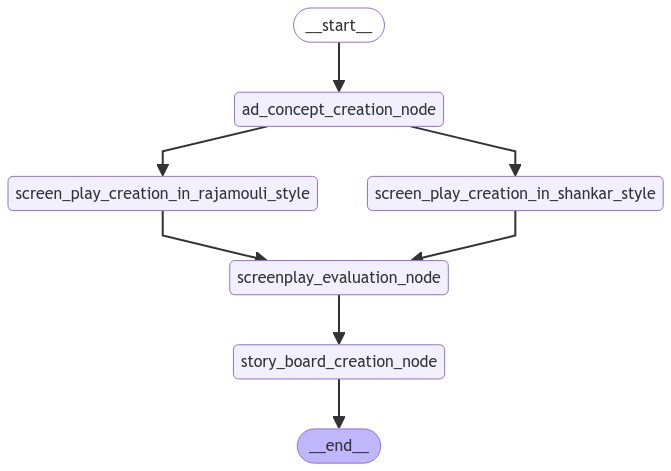

In [14]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [17]:
graph_input = {"theme": """Create an ad for the volkswagen taigun car"""}

# Run the graph until the first interruption
for output in app.stream(graph_input, stream_mode="values"):
    pass

------ENTERING: AD CONCEPT CREATION NODE------


**CONCEPT 1:**

<font color="navy">### Ad Concept: "Unleash Your Drive with the Volkswagen Taigun"

#### Visuals:
1. **Opening Scene**: A bustling cityscape at dawn, transitioning to serene countryside roads.
2. **Close-Up Shots**: The sleek exterior of the Volkswagen Taigun, highlighting its premium paint quality and robust build.
3. **Interior Focus**: Showcasing the luxurious and spacious interior, with a focus on the advanced infotainment system and comfortable seating.
4. **Driving Experience**: Dynamic shots of the Taigun navigating through city streets, highways, and off-road terrains, emphasizing its versatility and performance.
5. **Family and Friends**: Happy moments of a family and friends enjoying a road trip, capturing the essence of adventure and togetherness.
6. **Closing Scene**: The Taigun parked at a scenic viewpoint, with the tagline appearing on the screen.

#### Script:
**Narrator**: "Introducing the Volkswagen Taigun, where every journey becomes an adventure."

**Scene 1**: [Cityscape transitioning to countryside]
**Narrator**: "Designed for the passionate, ambitious, and energetic."

**Scene 2**: [Close-up of the exterior]
**Narrator**: "With a sleek design and premium build, the Taigun stands out in every crowd."

**Scene 3**: [Interior focus]
**Narrator**: "Step inside to experience unmatched comfort and cutting-edge technology."

**Scene 4**: [Driving through various terrains]
**Narrator**: "Powered by the robust 1.0-litre and 1.5-litre TSI engines, the Taigun delivers exceptional performance on every road."

**Scene 5**: [Family and friends enjoying a road trip]
**Narrator**: "Whether it's a city commute or a weekend getaway, the Taigun is your perfect companion."

**Scene 6**: [Scenic viewpoint]
**Narrator**: "Unleash your drive with the Volkswagen Taigun. Where will it take you next?"

**Tagline on Screen**: "Volkswagen Taigun - Unleash Your Drive"

#### Justification:
1. **Target Audience Alignment**: The ad speaks directly to the Taigun's target audience—passionate, ambitious, energetic, and upwardly mobile individuals. It showcases the car's versatility, making it appealing to both city dwellers and adventure seekers.
2. **Feature Highlighting**: By focusing on the car's premium build, advanced technology, and powerful engines, the ad effectively communicates the key selling points of the Taigun.
3. **Emotional Connection**: The inclusion of family and friends enjoying a road trip creates an emotional connection, emphasizing the car's role in creating memorable experiences.
4. **Visual Appeal**: The dynamic visuals and scenic backdrops enhance the overall appeal of the ad, making it visually engaging and memorable.

This concept aims to position the Volkswagen Taigun as a versatile, premium, and performance-driven SUV that caters to the lifestyle and aspirations of its target audience.</font>

------ENTERING: SCRENNPLAY CREATION NODE 1: In SS Rajamouli Style------
------ENTERING: SCRENNPLAY CREATION NODE 2: In Shankar Style------


**SCREENPLAY 1: In SS Rajamouli Style**

<font color="blue">### Title: "Unleash Your Drive with the Volkswagen Taigun"

### Genre: Action-Adventure, Drama

### Setting:
- **Primary Locations**: A bustling modern city, serene countryside roads, rugged mountain trails, and a scenic coastal viewpoint.
- **Time Period**: Present day, spanning from dawn to dusk.

### Characters:
- **Arjun**: A dynamic and ambitious young professional in his early 30s, passionate about adventure and exploration.
- **Maya**: Arjun's supportive and equally adventurous partner, who loves road trips and discovering new places.
- **Family and Friends**: A close-knit group of friends and family who join Arjun and Maya on their journey, adding warmth and camaraderie to the adventure.

### Plot Overview:
Arjun and Maya embark on an epic road trip in their Volkswagen Taigun, exploring diverse terrains and experiencing unforgettable moments with their loved ones. The journey showcases the Taigun's versatility, performance, and luxurious features, ultimately highlighting how it enhances their adventures and brings them closer together.

### Scenes:

#### Opening Scene:
- **Visuals**: A bustling cityscape at dawn, transitioning to serene countryside roads.
- **Sound**: Soft, uplifting background music with the sounds of the city waking up.
- **Action**: Arjun and Maya step out of their apartment, excitedly discussing their road trip plans. They walk towards their Volkswagen Taigun parked on the street.
- **Camera Transition**: Aerial shot of the city transitioning to a close-up of the Taigun.
- **Close-Up**: The sleek exterior of the Volkswagen Taigun, highlighting its premium paint quality and robust build.
- **Text on Screen**: "Unleash Your Drive with the Volkswagen Taigun"

#### Middle Scenes:

##### Scene 1:
- **Visuals**: The Taigun driving through the city streets, seamlessly navigating traffic.
- **Sound**: Energetic music with the hum of the engine.
- **Action**: Arjun skillfully maneuvers the Taigun through the city, showcasing its agility and performance.
- **Camera Transition**: Dynamic shots from various angles, including a bird's-eye view and close-ups of the wheels and headlights.
- **Dialogue**:
  - **Arjun**: "This car handles like a dream. Ready for the countryside, Maya?"
  - **Maya**: "Absolutely! Let's hit the road."

##### Scene 2:
- **Visuals**: The Taigun cruising on open countryside roads, surrounded by lush greenery.
- **Sound**: Calming music with the sounds of nature.
- **Action**: Arjun and Maya enjoy the scenic drive, with the sun rising in the background.
- **Camera Transition**: Wide shots of the landscape, interspersed with close-ups of the Taigun's interior.
- **Close-Up**: The luxurious and spacious interior, focusing on the advanced infotainment system and comfortable seating.
- **Dialogue**:
  - **Maya**: "This interior is so comfortable. And the infotainment system is top-notch."
  - **Arjun**: "It's like driving in a luxury suite."

##### Scene 3:
- **Visuals**: The Taigun navigating rugged mountain trails, demonstrating its off-road capabilities.
- **Sound**: Intense, adventurous music with the sound of gravel under the tires.
- **Action**: Arjun expertly drives the Taigun through challenging terrain, with Maya capturing the moments on her camera.
- **Camera Transition**: Close-ups of the wheels gripping the terrain, wide shots of the mountainous landscape.
- **Dialogue**:
  - **Maya**: "This car can handle anything! Look at those views!"
  - **Arjun**: "The Taigun is built for adventure."

##### Scene 4:
- **Visuals**: The Taigun driving along a coastal road, with the ocean on one side and cliffs on the other.
- **Sound**: Relaxing, melodic music with the sound of waves crashing.
- **Action**: Arjun and Maya, joined by their friends and family, enjoy a leisurely drive, laughing and sharing stories.
- **Camera Transition**: Shots of the group inside the car, interspersed with scenic views of the coastline.
- **Dialogue**:
  - **Friend**: "This is the best road trip ever!"
  - **Maya**: "All thanks to the Taigun."

#### Climactic Scene:
- **Visuals**: The Taigun parked at a scenic viewpoint, with the sun setting over the ocean.
- **Sound**: Emotional, uplifting music.
- **Action**: Arjun, Maya, and their loved ones step out of the car, taking in the breathtaking view. They set up a picnic and enjoy the moment together.
- **Camera Transition**: Wide shot of the group at the viewpoint, transitioning to close-ups of their happy faces.
- **Dialogue**:
  - **Arjun**: "This has been an unforgettable journey."
  - **Maya**: "And it's just the beginning."

#### Ending Scene:
- **Visuals**: The Taigun parked at the scenic viewpoint, with the tagline appearing on the screen.
- **Sound**: Soft, inspiring music.
- **Text on Screen**: "Volkswagen Taigun - Unleash Your Drive"
- **Narrator**: "Unleash your drive with the Volkswagen Taigun. Where will it take you next?"

### Additional Notes:
- **Color Palette**: Warm and vibrant colors to evoke a sense of adventure and joy.
- **Mood**: Energetic, adventurous, and emotionally resonant.
- **Character Consistency**: Arjun and Maya's adventurous spirit and strong bond are highlighted throughout the ad.
- **Signature Elements**: Heroic feats (navigating challenging terrains), moral dilemmas (choosing the right path), and visually stunning sequences (scenic landscapes).

This screenplay aims to create an engaging and emotionally resonant advertisement that showcases the Volkswagen Taigun's versatility, performance, and luxurious features, while also highlighting the joy of adventure and togetherness.</font>

**SCREENPLAY 2: In Shankar Style:**

<font color="green">### Title: "Unleash Your Drive with the Volkswagen Taigun"

### Genre: Inspirational Drama

### Setting:
- **Primary Locations**: A bustling modern city, serene countryside roads, and scenic viewpoints.
- **Time Period**: Present day, spanning from dawn to dusk.

### Characters:
- **Arjun**: A young, ambitious professional in his early 30s, passionate about his career and adventures.
- **Maya**: Arjun's supportive and adventurous wife, who loves exploring new places.
- **Rohan**: Arjun's best friend, a tech-savvy and fun-loving individual.
- **Aarav**: Arjun and Maya's energetic 5-year-old son, curious and full of life.

### Plot Overview:
Arjun, a driven professional, balances his demanding career with his love for adventure and family. The Volkswagen Taigun becomes his perfect companion, seamlessly transitioning from city commutes to weekend getaways. The ad showcases the Taigun's versatility, premium build, and advanced features, highlighting how it enhances Arjun's life and brings his family closer together.

### Scenes:

#### Opening Scene:
- **Visuals**: A bustling cityscape at dawn, transitioning to serene countryside roads.
- **Sound**: Soft, uplifting background music with the sounds of the city waking up.
- **Action**: Arjun gets ready for the day, grabs his keys, and heads to his Volkswagen Taigun parked outside his apartment.
- **Camera Transition**: Aerial shot of the city, zooming in on Arjun's apartment, then transitioning to a close-up of the Taigun.
- **Close-Up**: The sleek exterior of the Volkswagen Taigun, highlighting its premium paint quality and robust build.
- **Text on Screen**: "Introducing the Volkswagen Taigun"

#### Middle Scenes:

##### Scene 1:
- **Visuals**: Arjun driving through the city, the Taigun navigating smoothly through traffic.
- **Sound**: Energetic background music with city sounds.
- **Action**: Arjun smiles as he enjoys the drive, the cityscape reflecting on the car's windows.
- **Camera Transition**: Close-up of Arjun's face, then a wide shot of the car moving through the city.
- **Close-Up**: The Taigun's advanced infotainment system and comfortable seating.
- **Text on Screen**: "Designed for the passionate, ambitious, and energetic."

##### Scene 2:
- **Visuals**: The Taigun driving through countryside roads, surrounded by lush greenery.
- **Sound**: Calm, serene background music with nature sounds.
- **Action**: Arjun and Maya enjoy the drive, with Aarav playing in the backseat.
- **Camera Transition**: Wide shot of the car on the road, transitioning to close-ups of the family inside.
- **Close-Up**: The luxurious and spacious interior of the Taigun.
- **Text on Screen**: "Step inside to experience unmatched comfort and cutting-edge technology."

##### Scene 3:
- **Visuals**: The Taigun navigating through various terrains – city streets, highways, and off-road paths.
- **Sound**: Dynamic, adventurous background music.
- **Action**: The car effortlessly handles each terrain, showcasing its versatility and performance.
- **Camera Transition**: Dynamic shots of the car from different angles, highlighting its movement.
- **Close-Up**: The powerful 1.0-litre and 1.5-litre TSI engines.
- **Text on Screen**: "Powered by robust engines, the Taigun delivers exceptional performance on every road."

##### Scene 4:
- **Visuals**: Arjun, Maya, Rohan, and Aarav enjoying a road trip, laughing and taking photos.
- **Sound**: Joyful, upbeat background music.
- **Action**: The group stops at a scenic viewpoint, enjoying the view and each other's company.
- **Camera Transition**: Wide shot of the scenic viewpoint, transitioning to close-ups of the happy moments.
- **Close-Up**: The Taigun parked at the viewpoint, with the family in the background.
- **Text on Screen**: "Whether it's a city commute or a weekend getaway, the Taigun is your perfect companion."

#### Climactic Scene:
- **Visuals**: The Taigun driving up a winding mountain road at sunset, the sky painted in vibrant colors.
- **Sound**: Inspirational, dramatic background music.
- **Action**: Arjun and Maya share a meaningful look, feeling a sense of accomplishment and freedom.
- **Camera Transition**: Aerial shot of the car on the mountain road, transitioning to close-ups of Arjun and Maya.
- **Close-Up**: The Taigun's sleek design against the sunset backdrop.
- **Text on Screen**: "Unleash your drive with the Volkswagen Taigun."

#### Ending Scene:
- **Visuals**: The Taigun parked at a scenic viewpoint, with the family enjoying the view.
- **Sound**: Soft, uplifting background music.
- **Action**: The family stands together, looking out at the horizon, feeling united and content.
- **Camera Transition**: Wide shot of the family and the car, transitioning to a close-up of the Taigun's logo.
- **Text on Screen**: "Volkswagen Taigun - Unleash Your Drive"

### Justification:
1. **Target Audience Alignment**: The ad speaks directly to the Taigun's target audience—passionate, ambitious, energetic, and upwardly mobile individuals. It showcases the car's versatility, making it appealing to both city dwellers and adventure seekers.
2. **Feature Highlighting**: By focusing on the car's premium build, advanced technology, and powerful engines, the ad effectively communicates the key selling points of the Taigun.
3. **Emotional Connection**: The inclusion of family and friends enjoying a road trip creates an emotional connection, emphasizing the car's role in creating memorable experiences.
4. **Visual Appeal**: The dynamic visuals and scenic backdrops enhance the overall appeal of the ad, making it visually engaging and memorable.

This concept aims to position the Volkswagen Taigun as a versatile, premium, and performance-driven SUV that caters to the lifestyle and aspirations of its target audience.</font>

---------------------------------

Which screenplay did you like and proceed with?

1. Rajamouli 
2. Shankar 

Please enter 1 or 2!1


**SCREENPLAY WINNER:** <font color="red">[screenplay_1]</font>

<font color="red">### Title: "Unleash Your Drive with the Volkswagen Taigun"

### Genre: Action-Adventure, Drama

### Setting:
- **Primary Locations**: A bustling modern city, serene countryside roads, rugged mountain trails, and a scenic coastal viewpoint.
- **Time Period**: Present day, spanning from dawn to dusk.

### Characters:
- **Arjun**: A dynamic and ambitious young professional in his early 30s, passionate about adventure and exploration.
- **Maya**: Arjun's supportive and equally adventurous partner, who loves road trips and discovering new places.
- **Family and Friends**: A close-knit group of friends and family who join Arjun and Maya on their journey, adding warmth and camaraderie to the adventure.

### Plot Overview:
Arjun and Maya embark on an epic road trip in their Volkswagen Taigun, exploring diverse terrains and experiencing unforgettable moments with their loved ones. The journey showcases the Taigun's versatility, performance, and luxurious features, ultimately highlighting how it enhances their adventures and brings them closer together.

### Scenes:

#### Opening Scene:
- **Visuals**: A bustling cityscape at dawn, transitioning to serene countryside roads.
- **Sound**: Soft, uplifting background music with the sounds of the city waking up.
- **Action**: Arjun and Maya step out of their apartment, excitedly discussing their road trip plans. They walk towards their Volkswagen Taigun parked on the street.
- **Camera Transition**: Aerial shot of the city transitioning to a close-up of the Taigun.
- **Close-Up**: The sleek exterior of the Volkswagen Taigun, highlighting its premium paint quality and robust build.
- **Text on Screen**: "Unleash Your Drive with the Volkswagen Taigun"

#### Middle Scenes:

##### Scene 1:
- **Visuals**: The Taigun driving through the city streets, seamlessly navigating traffic.
- **Sound**: Energetic music with the hum of the engine.
- **Action**: Arjun skillfully maneuvers the Taigun through the city, showcasing its agility and performance.
- **Camera Transition**: Dynamic shots from various angles, including a bird's-eye view and close-ups of the wheels and headlights.
- **Dialogue**:
  - **Arjun**: "This car handles like a dream. Ready for the countryside, Maya?"
  - **Maya**: "Absolutely! Let's hit the road."

##### Scene 2:
- **Visuals**: The Taigun cruising on open countryside roads, surrounded by lush greenery.
- **Sound**: Calming music with the sounds of nature.
- **Action**: Arjun and Maya enjoy the scenic drive, with the sun rising in the background.
- **Camera Transition**: Wide shots of the landscape, interspersed with close-ups of the Taigun's interior.
- **Close-Up**: The luxurious and spacious interior, focusing on the advanced infotainment system and comfortable seating.
- **Dialogue**:
  - **Maya**: "This interior is so comfortable. And the infotainment system is top-notch."
  - **Arjun**: "It's like driving in a luxury suite."

##### Scene 3:
- **Visuals**: The Taigun navigating rugged mountain trails, demonstrating its off-road capabilities.
- **Sound**: Intense, adventurous music with the sound of gravel under the tires.
- **Action**: Arjun expertly drives the Taigun through challenging terrain, with Maya capturing the moments on her camera.
- **Camera Transition**: Close-ups of the wheels gripping the terrain, wide shots of the mountainous landscape.
- **Dialogue**:
  - **Maya**: "This car can handle anything! Look at those views!"
  - **Arjun**: "The Taigun is built for adventure."

##### Scene 4:
- **Visuals**: The Taigun driving along a coastal road, with the ocean on one side and cliffs on the other.
- **Sound**: Relaxing, melodic music with the sound of waves crashing.
- **Action**: Arjun and Maya, joined by their friends and family, enjoy a leisurely drive, laughing and sharing stories.
- **Camera Transition**: Shots of the group inside the car, interspersed with scenic views of the coastline.
- **Dialogue**:
  - **Friend**: "This is the best road trip ever!"
  - **Maya**: "All thanks to the Taigun."

#### Climactic Scene:
- **Visuals**: The Taigun parked at a scenic viewpoint, with the sun setting over the ocean.
- **Sound**: Emotional, uplifting music.
- **Action**: Arjun, Maya, and their loved ones step out of the car, taking in the breathtaking view. They set up a picnic and enjoy the moment together.
- **Camera Transition**: Wide shot of the group at the viewpoint, transitioning to close-ups of their happy faces.
- **Dialogue**:
  - **Arjun**: "This has been an unforgettable journey."
  - **Maya**: "And it's just the beginning."

#### Ending Scene:
- **Visuals**: The Taigun parked at the scenic viewpoint, with the tagline appearing on the screen.
- **Sound**: Soft, inspiring music.
- **Text on Screen**: "Volkswagen Taigun - Unleash Your Drive"
- **Narrator**: "Unleash your drive with the Volkswagen Taigun. Where will it take you next?"

### Additional Notes:
- **Color Palette**: Warm and vibrant colors to evoke a sense of adventure and joy.
- **Mood**: Energetic, adventurous, and emotionally resonant.
- **Character Consistency**: Arjun and Maya's adventurous spirit and strong bond are highlighted throughout the ad.
- **Signature Elements**: Heroic feats (navigating challenging terrains), moral dilemmas (choosing the right path), and visually stunning sequences (scenic landscapes).

This screenplay aims to create an engaging and emotionally resonant advertisement that showcases the Volkswagen Taigun's versatility, performance, and luxurious features, while also highlighting the joy of adventure and togetherness.</font>

------ENTERING: STORY BOARD CREATION NODE------


A bustling cityscape at dawn, transitioning to serene countryside roads. Arjun and Maya step out of their apartment, excitedly discussing their road trip plans. They walk towards their Volkswagen Taigun parked on the street. Aerial shot of the city transitioning to a close-up of the Taigun. Close-up of the sleek exterior of the Volkswagen Taigun, highlighting its premium paint quality and robust build. Text on Screen: 'Unleash Your Drive with the Volkswagen Taigun'. The mood is energetic and adventurous, with warm and vibrant colors.

----------------------

The Taigun driving through the city streets, seamlessly navigating traffic. Arjun skillfully maneuvers the Taigun through the city, showcasing its agility and performance. Dynamic shots from various angles, including a bird's-eye view and close-ups of the wheels and headlights. The mood is energetic and adventurous, with warm and vibrant colors.

----------------------

The Taigun cruising on open countryside roads, surrounded by lush greenery. Arjun and Maya enjoy the scenic drive, with the sun rising in the background. Wide shots of the landscape, interspersed with close-ups of the Taigun's interior. Close-up of the luxurious and spacious interior, focusing on the advanced infotainment system and comfortable seating. The mood is calming and adventurous, with warm and vibrant colors.

----------------------

The Taigun navigating rugged mountain trails, demonstrating its off-road capabilities. Arjun expertly drives the Taigun through challenging terrain, with Maya capturing the moments on her camera. Close-ups of the wheels gripping the terrain, wide shots of the mountainous landscape. The mood is intense and adventurous, with warm and vibrant colors.

----------------------

The Taigun driving along a coastal road, with the ocean on one side and cliffs on the other. Arjun and Maya, joined by their friends and family, enjoy a leisurely drive, laughing and sharing stories. Shots of the group inside the car, interspersed with scenic views of the coastline. The mood is relaxing and adventurous, with warm and vibrant colors.

----------------------

The Taigun parked at a scenic viewpoint, with the sun setting over the ocean. Arjun, Maya, and their loved ones step out of the car, taking in the breathtaking view. They set up a picnic and enjoy the moment together. Wide shot of the group at the viewpoint, transitioning to close-ups of their happy faces. The mood is emotional and uplifting, with warm and vibrant colors.

----------------------

The Taigun parked at the scenic viewpoint, with the tagline appearing on the screen. Text on Screen: 'Volkswagen Taigun - Unleash Your Drive'. The mood is soft and inspiring, with warm and vibrant colors.

----------------------

In [ ]:
graph_input = {"theme": """About the brand Rolex"""}

for output in app.stream(graph_input, stream_mode="values"):
    pass

------ENTERING: CONCEPT CREATION NODE 1------
------ENTERING: CONCEPT CREATION NODE 2------


**CONCEPT 2:** <font color="green">### Advertisement Concept: "Rolex - Timeless Excellence"

#### Concept Overview:
The advertisement will focus on the rich history and pioneering spirit of Rolex, emphasizing its journey from a visionary idea to a symbol of timeless excellence. The campaign will highlight key milestones and innovations, showcasing Rolex as not just a watch, but a legacy of precision, durability, and luxury.

#### Visual Elements:
1. **Historical Montage**: A series of black-and-white images and short clips showing Hans Wilsdorf, the founder, working on early designs, the first Rolex workshop, and the initial models.
2. **Innovations in Action**: Transition to color visuals showcasing the Oyster, the first waterproof wristwatch, being tested under extreme conditions, and other iconic models like the Submariner and Daytona in various adventurous and luxurious settings.
3. **Modern Masterpieces**: Close-up shots of the latest Rolex models, highlighting their intricate craftsmanship and modern features.
4. **Global Recognition**: Scenes of famous personalities and events where Rolex watches have been worn, emphasizing its status as a global icon.

#### Narrative:
The voiceover will narrate the journey of Rolex, starting from its inception in 1905 by Hans Wilsdorf and Alfred Davis, through its relocation to Geneva, and its numerous innovations that have set industry standards. The narrative will emphasize the brand's commitment to excellence and its role in significant historical moments.

#### Tagline:
"Rolex - Timeless Excellence"

#### Justification:
1. **Historical Depth**: By showcasing the brand's rich history, the advertisement builds a narrative of trust and legacy, appealing to both long-time enthusiasts and new customers.
2. **Innovation and Quality**: Highlighting key innovations like the Oyster and iconic models reinforces Rolex's reputation for quality and pioneering spirit.
3. **Emotional Connection**: The use of historical and modern visuals creates an emotional connection, showing that owning a Rolex is not just about telling time, but being part of a legacy.
4. **Global Appeal**: Featuring global recognition and famous personalities wearing Rolex watches underscores its status as a symbol of success and luxury worldwide.

This concept leverages the powerful history and innovations of Rolex to create a compelling narrative that resonates with a wide audience, reinforcing the brand's position as a leader in the luxury watch market.</font>

**CONCEPT 1:** <font color="blue">### Advertisement Concept for Rolex: "Timeless Legacy"

#### Concept Overview:
The advertisement will focus on the rich history and pioneering spirit of Rolex, emphasizing its journey from a visionary idea to a symbol of timeless excellence. The campaign will highlight key milestones and innovations that have defined Rolex, showcasing the brand's commitment to precision, durability, and elegance.

#### Visual Elements:
1. **Historical Montage**: The ad will open with a montage of black-and-white images and footage from the early 1900s, showing Hans Wilsdorf and the early days of Rolex. This will transition into colorful, modern-day scenes, illustrating the brand's evolution over more than a century.

2. **Iconic Watches**: Close-up shots of iconic Rolex models, such as the Oyster, Submariner, and Daytona, will be interspersed throughout the ad. Each watch will be shown in different settings, from deep-sea diving to high-stakes racing, highlighting their versatility and durability.

3. **Innovative Spirit**: Scenes of watchmakers at work in Rolex's Geneva headquarters, showcasing the meticulous craftsmanship and cutting-edge technology that go into every timepiece. This will be paired with historical footage of Rolex's pioneering achievements, such as the first waterproof wristwatch and the first wristwatch with an automatically changing date on the dial.

4. **Enduring Symbol**: The ad will feature the iconic Rolex crown logo, emphasizing its status as a symbol of excellence and prestige. The logo will be shown in various contexts, from the dials of watches to the wrists of influential figures throughout history.

#### Narrative:
The voiceover will tell the story of Hans Wilsdorf's vision and the relentless pursuit of perfection that has driven Rolex for over a century. It will highlight key moments in the brand's history, such as the creation of the Oyster in 1926 and the introduction of the Submariner in 1953, emphasizing how these innovations have set new standards in watchmaking.

#### Tagline:
"Rolex: A Timeless Legacy"

#### Justification:
1. **Historical Depth**: By focusing on the rich history and pioneering spirit of Rolex, the ad will appeal to both long-time enthusiasts and new customers who value tradition and innovation.

2. **Visual Appeal**: The combination of historical footage and modern-day scenes will create a visually engaging narrative that highlights the brand's evolution and enduring appeal.

3. **Emotional Connection**: The story of Hans Wilsdorf's vision and the brand's relentless pursuit of excellence will resonate with viewers, creating an emotional connection that reinforces the prestige and reliability of Rolex.

4. **Brand Identity**: The emphasis on iconic models and the Rolex crown logo will reinforce the brand's identity as a symbol of luxury, precision, and timeless elegance.

This concept leverages the rich history and innovative spirit of Rolex to create a compelling narrative that highlights the brand's enduring legacy and commitment to excellence.</font>

Which concept did you like and proceed with? Is it concept 1 or 2?1


**CONCEPT WINNER:** <font color="red">[concept_1]</font>

**CONCEPT:** <font color="red">[### Advertisement Concept for Rolex: "Timeless Legacy"

#### Concept Overview:
The advertisement will focus on the rich history and pioneering spirit of Rolex, emphasizing its journey from a visionary idea to a symbol of timeless excellence. The campaign will highlight key milestones and innovations that have defined Rolex, showcasing the brand's commitment to precision, durability, and elegance.

#### Visual Elements:
1. **Historical Montage**: The ad will open with a montage of black-and-white images and footage from the early 1900s, showing Hans Wilsdorf and the early days of Rolex. This will transition into colorful, modern-day scenes, illustrating the brand's evolution over more than a century.

2. **Iconic Watches**: Close-up shots of iconic Rolex models, such as the Oyster, Submariner, and Daytona, will be interspersed throughout the ad. Each watch will be shown in different settings, from deep-sea diving to high-stakes racing, highlighting their versatility and durability.

3. **Innovative Spirit**: Scenes of watchmakers at work in Rolex's Geneva headquarters, showcasing the meticulous craftsmanship and cutting-edge technology that go into every timepiece. This will be paired with historical footage of Rolex's pioneering achievements, such as the first waterproof wristwatch and the first wristwatch with an automatically changing date on the dial.

4. **Enduring Symbol**: The ad will feature the iconic Rolex crown logo, emphasizing its status as a symbol of excellence and prestige. The logo will be shown in various contexts, from the dials of watches to the wrists of influential figures throughout history.

#### Narrative:
The voiceover will tell the story of Hans Wilsdorf's vision and the relentless pursuit of perfection that has driven Rolex for over a century. It will highlight key moments in the brand's history, such as the creation of the Oyster in 1926 and the introduction of the Submariner in 1953, emphasizing how these innovations have set new standards in watchmaking.

#### Tagline:
"Rolex: A Timeless Legacy"

#### Justification:
1. **Historical Depth**: By focusing on the rich history and pioneering spirit of Rolex, the ad will appeal to both long-time enthusiasts and new customers who value tradition and innovation.

2. **Visual Appeal**: The combination of historical footage and modern-day scenes will create a visually engaging narrative that highlights the brand's evolution and enduring appeal.

3. **Emotional Connection**: The story of Hans Wilsdorf's vision and the brand's relentless pursuit of excellence will resonate with viewers, creating an emotional connection that reinforces the prestige and reliability of Rolex.

4. **Brand Identity**: The emphasis on iconic models and the Rolex crown logo will reinforce the brand's identity as a symbol of luxury, precision, and timeless elegance.

This concept leverages the rich history and innovative spirit of Rolex to create a compelling narrative that highlights the brand's enduring legacy and commitment to excellence.]</font>

------ENTERING: SCRENNPLAY CREATION NODE 1------------ENTERING: SCRENNPLAY CREATION NODE 2------



**SCREENPLAY 2:** <font color="green">### Title: "Timeless Legacy"

### Genre: Historical Drama

### Setting:
- **Early 1900s, London**: The humble beginnings of Rolex in a small workshop.
- **Mid-1900s, Various Locations**: Key moments in Rolex's history, including underwater expeditions and high-stakes racing events.
- **Modern Day, Geneva**: Rolex's state-of-the-art headquarters and manufacturing facilities.

### Characters:
- **Hans Wilsdorf**: The visionary founder of Rolex, driven by a relentless pursuit of perfection.
- **Watchmaker**: A skilled craftsman working at Rolex's Geneva headquarters, representing the brand's commitment to meticulous craftsmanship.
- **Diver**: An adventurous spirit who tests the durability of the Rolex Submariner in deep-sea expeditions.
- **Racer**: A daring race car driver who relies on the precision of the Rolex Daytona in high-stakes races.
- **Narrator**: A voiceover that guides the audience through the history and evolution of Rolex.

### Plot Overview:
The advertisement traces the journey of Rolex from its inception in the early 1900s to its current status as a symbol of timeless excellence. It highlights key milestones and innovations, showcasing the brand's commitment to precision, durability, and elegance. The narrative is driven by the vision of Hans Wilsdorf and the relentless pursuit of perfection that has defined Rolex for over a century.

### Scenes:

#### Opening Scene:
- **Visuals**: Black-and-white images and footage of early 1900s London, showing Hans Wilsdorf in his workshop.
- **Sound**: Soft, nostalgic piano music with the sound of a ticking clock.
- **Action**: Hans Wilsdorf meticulously working on a watch, surrounded by sketches and tools.
- **Camera Transition**: Slow zoom in on Hans's focused expression, transitioning to a close-up of his hands working on a watch.
- **Close-Up**: The intricate details of the watch mechanism.
- **Text on Screen**: "Rolex: A Timeless Legacy"

#### Middle Scenes:
1. **Scene 1: The Oyster**
   - **Visuals**: Historical footage of the first waterproof wristwatch, the Rolex Oyster, being tested underwater.
   - **Sound**: The sound of water splashing and a triumphant orchestral score.
   - **Action**: A diver submerging the watch in water, emerging with it still ticking perfectly.
   - **Camera Transition**: Underwater shots transitioning to the diver's satisfied expression.
   - **Close-Up**: The Rolex Oyster, water droplets glistening on its surface.
   - **Text on Screen**: "1926: The First Waterproof Wristwatch"

2. **Scene 2: The Submariner**
   - **Visuals**: Colorful, dynamic scenes of deep-sea diving expeditions.
   - **Sound**: The sound of bubbles and an adventurous musical score.
   - **Action**: A diver exploring underwater caves, relying on the Rolex Submariner.
   - **Camera Transition**: Wide shots of the underwater landscape transitioning to close-ups of the watch.
   - **Close-Up**: The Rolex Submariner, glowing in the underwater light.
   - **Text on Screen**: "1953: The Submariner - A Diver's Best Friend"

3. **Scene 3: The Daytona**
   - **Visuals**: High-energy scenes of a race car speeding around a track.
   - **Sound**: The roar of the engine and an intense, fast-paced musical score.
   - **Action**: A racer checking the Rolex Daytona on his wrist as he navigates the track.
   - **Camera Transition**: Fast cuts between the racer's focused expression and the watch.
   - **Close-Up**: The Rolex Daytona, its chronograph functions in action.
   - **Text on Screen**: "1963: The Daytona - Precision on the Track"

4. **Scene 4: Modern Day Craftsmanship**
   - **Visuals**: Scenes of watchmakers at work in Rolex's Geneva headquarters.
   - **Sound**: The sound of delicate tools and a serene, focused musical score.
   - **Action**: Watchmakers meticulously assembling and testing watches.
   - **Camera Transition**: Smooth pans across the workshop, focusing on the intricate details of the process.
   - **Close-Up**: The hands of a watchmaker, the inner workings of a watch, and the finished product.
   - **Text on Screen**: "Craftsmanship and Innovation"

#### Climactic Scene:
- **Visuals**: A montage of influential figures throughout history wearing Rolex watches, from explorers to athletes to world leaders.
- **Sound**: A powerful, uplifting orchestral score.
- **Action**: The montage culminates in a modern-day scene of a young professional putting on a Rolex watch.
- **Camera Transition**: Seamless transitions between historical and modern-day scenes.
- **Close-Up**: The Rolex crown logo on the watch dial.
- **Text on Screen**: "Rolex: A Symbol of Excellence"

#### Ending Scene:
- **Visuals**: The iconic Rolex crown logo, shining brightly.
- **Sound**: The sound of a ticking clock, fading into silence.
- **Action**: The screen fades to black, leaving the logo as the final image.
- **Camera Transition**: A slow zoom out from the logo.
- **Close-Up**: The Rolex crown logo.
- **Text on Screen**: "Rolex: A Timeless Legacy"

### Additional Notes:
- **Color Palette**: The ad will transition from black-and-white to vibrant colors, symbolizing the evolution of Rolex.
- **Mood**: The ad will evoke a sense of nostalgia, adventure, and prestige.
- **Character Consistency**: Hans Wilsdorf's vision and the brand's commitment to excellence will be central themes throughout the ad.
- **Signature Elements**: Grandiose visuals, intricate storytelling, and a focus on socially relevant themes such as innovation and excellence will be incorporated to reflect Shankar's cinematic style.</font>

**SCREENPLAY 1:** <font color="blue">### Title: "Timeless Legacy"

### Genre: Historical Drama

### Setting:
- **Early 1900s, London**: The bustling streets and workshops where Hans Wilsdorf first envisioned Rolex.
- **Mid-20th Century, Various Locations**: Key moments in Rolex's history, including underwater expeditions and high-stakes racing events.
- **Modern Day, Geneva**: The state-of-the-art Rolex headquarters, showcasing the brand's current innovations and craftsmanship.

### Characters:
- **Hans Wilsdorf**: The visionary founder of Rolex, driven by a relentless pursuit of perfection.
- **Watchmaker**: A skilled craftsman working at Rolex's Geneva headquarters, representing the brand's commitment to meticulous craftsmanship.
- **Diver**: An adventurous spirit who uses the Rolex Submariner in deep-sea explorations.
- **Racer**: A daring race car driver who relies on the Rolex Daytona for precision timing.
- **Narrator**: A voiceover that guides the audience through the brand's history and milestones.

### Plot Overview:
The advertisement traces the journey of Rolex from its inception in the early 1900s to its current status as a symbol of timeless excellence. It highlights key innovations and milestones, showcasing the brand's commitment to precision, durability, and elegance. The narrative is driven by Hans Wilsdorf's vision and the relentless pursuit of perfection that has defined Rolex for over a century.

### Scenes:

#### Opening Scene:
- **Visuals**: Black-and-white images and footage of early 1900s London, transitioning to colorful, modern-day scenes.
- **Sound**: A stirring orchestral score begins softly, building in intensity.
- **Action**: Hans Wilsdorf is seen sketching designs and working in his workshop. The scene transitions to modern-day Geneva, where watchmakers are meticulously crafting Rolex timepieces.
- **Camera Transition**: Slow zoom in on Wilsdorf's sketches, transitioning to a close-up of a modern Rolex watch being assembled.
- **Close-Up**: Hans Wilsdorf's determined face, the intricate details of a Rolex watch.
- **Text on Screen**: "Rolex: A Timeless Legacy"

#### Middle Scenes:

##### Scene 1: The Oyster
- **Visuals**: Historical footage of the creation of the Oyster in 1926.
- **Sound**: The sound of ticking clocks and the hum of machinery.
- **Action**: Wilsdorf tests the waterproof capabilities of the Oyster, submerging it in water.
- **Camera Transition**: Close-up of the Oyster being submerged, transitioning to a modern diver using the Submariner.
- **Close-Up**: The Oyster watch, water droplets on its surface.
- **Text on Screen**: "1926: The First Waterproof Wristwatch"

##### Scene 2: The Submariner
- **Visuals**: Underwater scenes of a diver exploring the depths of the ocean.
- **Sound**: The sound of bubbles and the deep, resonant tones of the ocean.
- **Action**: The diver checks the time on his Rolex Submariner, highlighting its durability and precision.
- **Camera Transition**: Wide shot of the ocean, transitioning to a close-up of the Submariner on the diver's wrist.
- **Close-Up**: The Submariner watch, the diver's focused expression.
- **Text on Screen**: "1953: The Submariner - A New Standard in Diving"

##### Scene 3: The Daytona
- **Visuals**: High-speed racing scenes, with cars zooming around a track.
- **Sound**: The roar of engines and the cheers of the crowd.
- **Action**: The racer glances at his Rolex Daytona, timing his laps with precision.
- **Camera Transition**: Fast-paced shots of the race, transitioning to a close-up of the Daytona on the racer's wrist.
- **Close-Up**: The Daytona watch, the racer's intense focus.
- **Text on Screen**: "1963: The Daytona - Precision in Motion"

#### Climactic Scene:
- **Visuals**: A montage of Rolex's iconic moments and innovations, from the Oyster to the Daytona.
- **Sound**: The orchestral score reaches a crescendo, underscoring the brand's achievements.
- **Action**: The watchmaker in Geneva completes a new Rolex timepiece, holding it up with pride.
- **Camera Transition**: A sweeping shot of the Rolex headquarters, transitioning to a close-up of the new watch.
- **Close-Up**: The new Rolex watch, the watchmaker's satisfied smile.
- **Text on Screen**: "Rolex: A Legacy of Excellence"

#### Ending Scene:
- **Visuals**: The iconic Rolex crown logo, shown in various contexts.
- **Sound**: The orchestral score fades to a triumphant conclusion.
- **Action**: Influential figures throughout history are seen wearing Rolex watches, symbolizing the brand's enduring legacy.
- **Camera Transition**: Slow zoom out from the Rolex crown logo to a wide shot of the world, highlighting the brand's global impact.
- **Close-Up**: The Rolex crown logo.
- **Text on Screen**: "Rolex: A Timeless Legacy"

### Additional Notes:
- The color palette transitions from sepia tones in the historical scenes to vibrant colors in the modern-day scenes, symbolizing the brand's evolution.
- The mood is one of reverence and admiration, underscoring the brand's prestigious history and commitment to excellence.
- The characters' determination and passion reflect the brand's values, creating an emotional connection with the audience.
- The screenplay incorporates Rajamouli's signature elements, such as heroic feats, moral dilemmas, and visually stunning sequences, to create a captivating and emotionally resonant narrative.</font>

Which screenplay did you like and proceed with? Is it 1 or 2?1


**SCREENPLAY WINNER:** <font color="red">[screenplay_1]</font>

**SCREENPLAY:** <font color="red">[### Title: "Timeless Legacy"

### Genre: Historical Drama

### Setting:
- **Early 1900s, London**: The bustling streets and workshops where Hans Wilsdorf first envisioned Rolex.
- **Mid-20th Century, Various Locations**: Key moments in Rolex's history, including underwater expeditions and high-stakes racing events.
- **Modern Day, Geneva**: The state-of-the-art Rolex headquarters, showcasing the brand's current innovations and craftsmanship.

### Characters:
- **Hans Wilsdorf**: The visionary founder of Rolex, driven by a relentless pursuit of perfection.
- **Watchmaker**: A skilled craftsman working at Rolex's Geneva headquarters, representing the brand's commitment to meticulous craftsmanship.
- **Diver**: An adventurous spirit who uses the Rolex Submariner in deep-sea explorations.
- **Racer**: A daring race car driver who relies on the Rolex Daytona for precision timing.
- **Narrator**: A voiceover that guides the audience through the brand's history and milestones.

### Plot Overview:
The advertisement traces the journey of Rolex from its inception in the early 1900s to its current status as a symbol of timeless excellence. It highlights key innovations and milestones, showcasing the brand's commitment to precision, durability, and elegance. The narrative is driven by Hans Wilsdorf's vision and the relentless pursuit of perfection that has defined Rolex for over a century.

### Scenes:

#### Opening Scene:
- **Visuals**: Black-and-white images and footage of early 1900s London, transitioning to colorful, modern-day scenes.
- **Sound**: A stirring orchestral score begins softly, building in intensity.
- **Action**: Hans Wilsdorf is seen sketching designs and working in his workshop. The scene transitions to modern-day Geneva, where watchmakers are meticulously crafting Rolex timepieces.
- **Camera Transition**: Slow zoom in on Wilsdorf's sketches, transitioning to a close-up of a modern Rolex watch being assembled.
- **Close-Up**: Hans Wilsdorf's determined face, the intricate details of a Rolex watch.
- **Text on Screen**: "Rolex: A Timeless Legacy"

#### Middle Scenes:

##### Scene 1: The Oyster
- **Visuals**: Historical footage of the creation of the Oyster in 1926.
- **Sound**: The sound of ticking clocks and the hum of machinery.
- **Action**: Wilsdorf tests the waterproof capabilities of the Oyster, submerging it in water.
- **Camera Transition**: Close-up of the Oyster being submerged, transitioning to a modern diver using the Submariner.
- **Close-Up**: The Oyster watch, water droplets on its surface.
- **Text on Screen**: "1926: The First Waterproof Wristwatch"

##### Scene 2: The Submariner
- **Visuals**: Underwater scenes of a diver exploring the depths of the ocean.
- **Sound**: The sound of bubbles and the deep, resonant tones of the ocean.
- **Action**: The diver checks the time on his Rolex Submariner, highlighting its durability and precision.
- **Camera Transition**: Wide shot of the ocean, transitioning to a close-up of the Submariner on the diver's wrist.
- **Close-Up**: The Submariner watch, the diver's focused expression.
- **Text on Screen**: "1953: The Submariner - A New Standard in Diving"

##### Scene 3: The Daytona
- **Visuals**: High-speed racing scenes, with cars zooming around a track.
- **Sound**: The roar of engines and the cheers of the crowd.
- **Action**: The racer glances at his Rolex Daytona, timing his laps with precision.
- **Camera Transition**: Fast-paced shots of the race, transitioning to a close-up of the Daytona on the racer's wrist.
- **Close-Up**: The Daytona watch, the racer's intense focus.
- **Text on Screen**: "1963: The Daytona - Precision in Motion"

#### Climactic Scene:
- **Visuals**: A montage of Rolex's iconic moments and innovations, from the Oyster to the Daytona.
- **Sound**: The orchestral score reaches a crescendo, underscoring the brand's achievements.
- **Action**: The watchmaker in Geneva completes a new Rolex timepiece, holding it up with pride.
- **Camera Transition**: A sweeping shot of the Rolex headquarters, transitioning to a close-up of the new watch.
- **Close-Up**: The new Rolex watch, the watchmaker's satisfied smile.
- **Text on Screen**: "Rolex: A Legacy of Excellence"

#### Ending Scene:
- **Visuals**: The iconic Rolex crown logo, shown in various contexts.
- **Sound**: The orchestral score fades to a triumphant conclusion.
- **Action**: Influential figures throughout history are seen wearing Rolex watches, symbolizing the brand's enduring legacy.
- **Camera Transition**: Slow zoom out from the Rolex crown logo to a wide shot of the world, highlighting the brand's global impact.
- **Close-Up**: The Rolex crown logo.
- **Text on Screen**: "Rolex: A Timeless Legacy"

### Additional Notes:
- The color palette transitions from sepia tones in the historical scenes to vibrant colors in the modern-day scenes, symbolizing the brand's evolution.
- The mood is one of reverence and admiration, underscoring the brand's prestigious history and commitment to excellence.
- The characters' determination and passion reflect the brand's values, creating an emotional connection with the audience.
- The screenplay incorporates Rajamouli's signature elements, such as heroic feats, moral dilemmas, and visually stunning sequences, to create a captivating and emotionally resonant narrative.]</font>

------ENTERING: STORY BOARD CREATION NODE------


Black-and-white images and footage of early 1900s London, transitioning to colorful, modern-day scenes. Hans Wilsdorf is seen sketching designs and working in his workshop. The scene transitions to modern-day Geneva, where watchmakers are meticulously crafting Rolex timepieces. Slow zoom in on Wilsdorf's sketches, transitioning to a close-up of a modern Rolex watch being assembled. Close-up of Hans Wilsdorf's determined face, the intricate details of a Rolex watch. Text on Screen: 'Rolex: A Timeless Legacy'

Historical footage of the creation of the Oyster in 1926. Wilsdorf tests the waterproof capabilities of the Oyster, submerging it in water. Close-up of the Oyster being submerged, transitioning to a modern diver using the Submariner. Close-up of the Oyster watch, water droplets on its surface. Text on Screen: '1926: The First Waterproof Wristwatch'

Underwater scenes of a diver exploring the depths of the ocean. The diver checks the time on his Rolex Submariner, highlighting its durability and precision. Wide shot of the ocean, transitioning to a close-up of the Submariner on the diver's wrist. Close-up of the Submariner watch, the diver's focused expression. Text on Screen: '1953: The Submariner - A New Standard in Diving'

High-speed racing scenes, with cars zooming around a track. The racer glances at his Rolex Daytona, timing his laps with precision. Fast-paced shots of the race, transitioning to a close-up of the Daytona on the racer's wrist. Close-up of the Daytona watch, the racer's intense focus. Text on Screen: '1963: The Daytona - Precision in Motion'

A montage of Rolex's iconic moments and innovations, from the Oyster to the Daytona. The watchmaker in Geneva completes a new Rolex timepiece, holding it up with pride. A sweeping shot of the Rolex headquarters, transitioning to a close-up of the new watch. Close-up of the new Rolex watch, the watchmaker's satisfied smile. Text on Screen: 'Rolex: A Legacy of Excellence'

The iconic Rolex crown logo, shown in various contexts. Influential figures throughout history are seen wearing Rolex watches, symbolizing the brand's enduring legacy. Slow zoom out from the Rolex crown logo to a wide shot of the world, highlighting the brand's global impact. Close-up of the Rolex crown logo. Text on Screen: 'Rolex: A Timeless Legacy'

In [ ]:
graph_input = {"theme": """Advertisement is about Fivestar chocolate and the theme is do nothing and eat five star"""}

for output in app.stream(graph_input, stream_mode="values"):
    pass

{'theme': 'Advertisement is about Fivestar chocolate and the theme is do nothing and eat five star', 'overall_status': ''}
------ENTERING: CONCEPT CREATION NODE 1------
------ENTERING: CONCEPT CREATION NODE 2------


**CONCEPT 1:** <font color="blue">### Advertisement Concept: "The Art of Doing Nothing with Fivestar"

#### Concept Overview:
The advertisement will revolve around the idea that indulging in a Fivestar chocolate bar is the ultimate way to embrace the art of doing nothing. The campaign will highlight how Fivestar's rich, creamy texture and delicious taste make it the perfect companion for those moments when you just want to relax and do absolutely nothing.

#### Visual Elements:
1. **Setting**: A cozy, serene environment such as a hammock in a lush garden, a comfy couch in a sunlit living room, or a peaceful lakeside spot.
2. **Characters**: A diverse group of people (different ages, genders, and ethnicities) all enjoying their Fivestar chocolate in various "do nothing" scenarios.
3. **Mood**: Calm, relaxed, and content. The visuals should evoke a sense of peace and satisfaction.

#### Storyboard:
1. **Opening Scene**: A person is seen rushing through a busy day, juggling multiple tasks. The screen then fades to black with the text: "In a world that's always on the go..."
2. **Transition**: The scene transitions to a slow-motion shot of someone unwrapping a Fivestar chocolate bar. The background music shifts to a soothing, mellow tune.
3. **Main Scene**: Various people are shown in different settings, all doing nothing but enjoying their Fivestar chocolate. One person is lying in a hammock, another is lounging on a couch, and another is sitting by a lake. Each person has a look of pure bliss on their face.
4. **Close-Up Shots**: Close-up shots of the Fivestar chocolate being bitten into, showing its rich, creamy texture.
5. **Tagline**: The screen fades to black again, and the text appears: "Do Nothing. Eat Fivestar." followed by the Fivestar logo.

#### Justification:
1. **Relatability**: In today's fast-paced world, the idea of taking a moment to do nothing is highly appealing. This concept taps into the universal desire for relaxation and self-indulgence.
2. **Emotional Connection**: By associating Fivestar with moments of peace and contentment, the advertisement creates a strong emotional connection with the audience.
3. **Visual Appeal**: The serene and calming visuals will stand out and capture the viewer's attention, making the advertisement memorable.
4. **Simplicity**: The straightforward message of "Do Nothing. Eat Fivestar." is easy to understand and remember, making it effective for brand recall.

This concept leverages the universal appeal of relaxation and indulgence, positioning Fivestar as the perfect treat for those precious moments of doing nothing.</font>

**CONCEPT 2:** <font color="green">### Advertisement Concept: "The Art of Doing Nothing with Fivestar"

#### Concept Overview:
The advertisement will revolve around the idea that indulging in a Fivestar chocolate bar is the ultimate way to embrace the art of doing nothing. The campaign will highlight how Fivestar's rich, creamy texture and delicious taste make it the perfect companion for those moments when you just want to relax and do absolutely nothing.

#### Visual Elements:
1. **Setting**: A cozy, serene environment such as a hammock in a lush garden, a comfy couch in a sunlit living room, or a peaceful lakeside spot.
2. **Characters**: A diverse group of people (different ages, genders, and ethnicities) all enjoying their Fivestar chocolate in various "doing nothing" scenarios.
3. **Mood**: Calm, relaxed, and content. The visuals should evoke a sense of peace and satisfaction.

#### Storyboard:
1. **Opening Scene**: A close-up of a Fivestar chocolate bar being unwrapped slowly, with the sound of the wrapper crinkling.
2. **Scene 2**: Cut to a person lying in a hammock, taking a bite of the Fivestar chocolate. The camera zooms in on their face, showing a look of pure bliss.
3. **Scene 3**: Another person is seen lounging on a couch, flipping through channels on TV, but they stop and smile as they take a bite of their Fivestar.
4. **Scene 4**: A young woman is sitting by a lake, dipping her toes in the water, and savoring her Fivestar chocolate.
5. **Scene 5**: A montage of different people in various relaxing settings, all enjoying their Fivestar chocolate and doing nothing.
6. **Closing Scene**: The screen fades to black with the text "Do Nothing. Eat Fivestar." appearing, followed by the Fivestar logo and a final shot of the chocolate bar.

#### Justification:
1. **Relatability**: The concept taps into a universal desire to take a break from the hustle and bustle of daily life and simply relax. Everyone can relate to the need for downtime.
2. **Emotional Appeal**: By associating Fivestar chocolate with moments of relaxation and contentment, the advertisement creates a positive emotional connection with the audience.
3. **Visual Appeal**: The serene and cozy settings will draw viewers in and make them feel like they are part of the relaxing experience.
4. **Simplicity**: The straightforward message of "Do Nothing. Eat Fivestar." is easy to understand and remember, making it effective for brand recall.

#### Tagline:
"Do Nothing. Eat Fivestar."

This concept leverages the idea that sometimes the best thing to do is nothing at all, especially when you have a delicious Fivestar chocolate to enjoy.</font>

{'theme': 'Advertisement is about Fivestar chocolate and the theme is do nothing and eat five star', 'concept_1': '### Advertisement Concept: "The Art of Doing Nothing with Fivestar"\n\n#### Concept Overview:\nThe advertisement will revolve around the idea that indulging in a Fivestar chocolate bar is the ultimate way to embrace the art of doing nothing. The campaign will highlight how Fivestar\'s rich, creamy texture and delicious taste make it the perfect companion for those moments when you just want to relax and do absolutely nothing.\n\n#### Visual Elements:\n1. **Setting**: A cozy, serene environment such as a hammock in a lush garden, a comfy couch in a sunlit living room, or a peaceful lakeside spot.\n2. **Characters**: A diverse group of people (different ages, genders, and ethnicities) all enjoying their Fivestar chocolate in various "do nothing" scenarios.\n3. **Mood**: Calm, relaxed, and content. The visuals should evoke a sense of peace and satisfaction.\n\n#### Storyboard

**CONCEPT WINNER:** <font color="red">[concept_1]</font>

**CONCEPT:** <font color="red">[### Advertisement Concept: "The Art of Doing Nothing with Fivestar"

#### Concept Overview:
The advertisement will revolve around the idea that indulging in a Fivestar chocolate bar is the ultimate way to embrace the art of doing nothing. The campaign will highlight how Fivestar's rich, creamy texture and delicious taste make it the perfect companion for those moments when you just want to relax and do absolutely nothing.

#### Visual Elements:
1. **Setting**: A cozy, serene environment such as a hammock in a lush garden, a comfy couch in a sunlit living room, or a peaceful lakeside spot.
2. **Characters**: A diverse group of people (different ages, genders, and ethnicities) all enjoying their Fivestar chocolate in various "do nothing" scenarios.
3. **Mood**: Calm, relaxed, and content. The visuals should evoke a sense of peace and satisfaction.

#### Storyboard:
1. **Opening Scene**: A person is seen rushing through a busy day, juggling multiple tasks. The screen then fades to black with the text: "In a world that's always on the go..."
2. **Transition**: The scene transitions to a slow-motion shot of someone unwrapping a Fivestar chocolate bar. The background music shifts to a soothing, mellow tune.
3. **Main Scene**: Various people are shown in different settings, all doing nothing but enjoying their Fivestar chocolate. One person is lying in a hammock, another is lounging on a couch, and another is sitting by a lake. Each person has a look of pure bliss on their face.
4. **Close-Up Shots**: Close-up shots of the Fivestar chocolate being bitten into, showing its rich, creamy texture.
5. **Tagline**: The screen fades to black again, and the text appears: "Do Nothing. Eat Fivestar." followed by the Fivestar logo.

#### Justification:
1. **Relatability**: In today's fast-paced world, the idea of taking a moment to do nothing is highly appealing. This concept taps into the universal desire for relaxation and self-indulgence.
2. **Emotional Connection**: By associating Fivestar with moments of peace and contentment, the advertisement creates a strong emotional connection with the audience.
3. **Visual Appeal**: The serene and calming visuals will stand out and capture the viewer's attention, making the advertisement memorable.
4. **Simplicity**: The straightforward message of "Do Nothing. Eat Fivestar." is easy to understand and remember, making it effective for brand recall.

This concept leverages the universal appeal of relaxation and indulgence, positioning Fivestar as the perfect treat for those precious moments of doing nothing.]</font>

{'theme': 'Advertisement is about Fivestar chocolate and the theme is do nothing and eat five star', 'concept_1': '### Advertisement Concept: "The Art of Doing Nothing with Fivestar"\n\n#### Concept Overview:\nThe advertisement will revolve around the idea that indulging in a Fivestar chocolate bar is the ultimate way to embrace the art of doing nothing. The campaign will highlight how Fivestar\'s rich, creamy texture and delicious taste make it the perfect companion for those moments when you just want to relax and do absolutely nothing.\n\n#### Visual Elements:\n1. **Setting**: A cozy, serene environment such as a hammock in a lush garden, a comfy couch in a sunlit living room, or a peaceful lakeside spot.\n2. **Characters**: A diverse group of people (different ages, genders, and ethnicities) all enjoying their Fivestar chocolate in various "do nothing" scenarios.\n3. **Mood**: Calm, relaxed, and content. The visuals should evoke a sense of peace and satisfaction.\n\n#### Storyboard

**SCREENPLAY 2:** <font color="green">### Screenplay for 30-Second Advertisement: "The Art of Doing Nothing with Fivestar"

#### Scene 1: Opening Scene (0-5 seconds)
- **Visual**: A bustling city street. People are rushing, cars honking, and a person (let's call him Alex) is seen juggling multiple tasks—talking on the phone, carrying a briefcase, and trying to hail a cab.
- **Audio**: The sound of city noise, hurried footsteps, and a phone ringing.
- **Text on Screen**: "In a world that's always on the go..."

#### Scene 2: Transition (5-10 seconds)
- **Visual**: The screen fades to black. The noise fades out, replaced by a soothing, mellow tune. The scene transitions to a slow-motion shot of Alex unwrapping a Fivestar chocolate bar.
- **Audio**: Soft, calming music begins to play.
- **Text on Screen**: "Take a moment..."

#### Scene 3: Main Scene (10-25 seconds)
- **Visual**: 
  - **Shot 1**: Alex is now lying in a hammock in a lush garden, gently swaying with a look of pure bliss on his face as he takes a bite of the Fivestar chocolate.
  - **Shot 2**: A woman (let's call her Priya) is lounging on a comfy couch in a sunlit living room, eyes closed, savoring the taste of Fivestar.
  - **Shot 3**: An elderly man (let's call him Mr. Singh) is sitting by a peaceful lakeside, dipping his feet in the water, and enjoying his Fivestar chocolate.
- **Audio**: The soothing music continues, with occasional sounds of nature like birds chirping and water gently lapping.
- **Visual Details**: Each character has a look of pure contentment and relaxation, emphasizing the theme of doing nothing.

#### Scene 4: Close-Up Shots (25-28 seconds)
- **Visual**: Close-up shots of the Fivestar chocolate being bitten into, showing its rich, creamy texture. The camera captures the smooth chocolate and caramel layers.
- **Audio**: The sound of the chocolate being bitten into, enhancing the sensory experience.

#### Scene 5: Tagline and Logo (28-30 seconds)
- **Visual**: The screen fades to black again. The text appears: "Do Nothing. Eat Fivestar." followed by the Fivestar logo.
- **Audio**: The soothing music fades out, leaving a moment of silence for impact.

#### Justification:
1. **Relatability**: The opening scene captures the hectic pace of modern life, making the transition to relaxation with Fivestar highly relatable.
2. **Emotional Connection**: The serene and content expressions of the characters create a strong emotional connection, associating Fivestar with moments of peace and indulgence.
3. **Visual Appeal**: The calming visuals and close-up shots of the chocolate enhance the sensory appeal, making the advertisement memorable.
4. **Simplicity**: The straightforward message of "Do Nothing. Eat Fivestar." is easy to understand and remember, ensuring effective brand recall.

This screenplay leverages the universal appeal of relaxation and indulgence, positioning Fivestar as the perfect treat for those precious moments of doing nothing.</font>

**SCREENPLAY 1:** <font color="blue">### Advertisement Concept: "The Art of Doing Nothing with Fivestar"

#### Concept Overview:
The advertisement will revolve around the idea that indulging in a Fivestar chocolate bar is the ultimate way to embrace the art of doing nothing. The campaign will highlight how Fivestar's rich, creamy texture and delicious taste make it the perfect companion for those moments when you just want to relax and do absolutely nothing.

#### Visual Elements:
1. **Setting**: A cozy, serene environment such as a hammock in a lush garden, a comfy couch in a sunlit living room, or a peaceful lakeside spot.
2. **Characters**: A diverse group of people (different ages, genders, and ethnicities) all enjoying their Fivestar chocolate in various "do nothing" scenarios.
3. **Mood**: Calm, relaxed, and content. The visuals should evoke a sense of peace and satisfaction.

#### Storyboard:
1. **Opening Scene**: A person is seen rushing through a busy day, juggling multiple tasks. The screen then fades to black with the text: "In a world that's always on the go..."
2. **Transition**: The scene transitions to a slow-motion shot of someone unwrapping a Fivestar chocolate bar. The background music shifts to a soothing, mellow tune.
3. **Main Scene**: Various people are shown in different settings, all doing nothing but enjoying their Fivestar chocolate. One person is lying in a hammock, another is lounging on a couch, and another is sitting by a lake. Each person has a look of pure bliss on their face.
4. **Close-Up Shots**: Close-up shots of the Fivestar chocolate being bitten into, showing its rich, creamy texture.
5. **Tagline**: The screen fades to black again, and the text appears: "Do Nothing. Eat Fivestar." followed by the Fivestar logo.

#### Justification:
1. **Relatability**: In today's fast-paced world, the idea of taking a moment to do nothing is highly appealing. This concept taps into the universal desire for relaxation and self-indulgence.
2. **Emotional Connection**: By associating Fivestar with moments of peace and contentment, the advertisement creates a strong emotional connection with the audience.
3. **Visual Appeal**: The serene and calming visuals will stand out and capture the viewer's attention, making the advertisement memorable.
4. **Simplicity**: The straightforward message of "Do Nothing. Eat Fivestar." is easy to understand and remember, making it effective for brand recall.

This concept leverages the universal appeal of relaxation and indulgence, positioning Fivestar as the perfect treat for those precious moments of doing nothing.

### Detailed Screenplay

#### Opening Scene
**[INT. OFFICE - DAY]**

*The camera follows a young woman, ANITA, in her late 20s, as she rushes through a busy office. Papers are flying, phones are ringing, and she’s juggling multiple tasks. The camera zooms in on her stressed face.*

**TEXT ON SCREEN: "In a world that's always on the go..."**

*The screen fades to black.*

#### Transition
**[EXT. GARDEN - DAY]**

*The scene transitions to a slow-motion shot of a hand unwrapping a Fivestar chocolate bar. The background music shifts to a soothing, mellow tune. The camera captures the rich, creamy texture of the chocolate as it is unwrapped.*

#### Main Scene
**[EXT. GARDEN - DAY]**

*The camera pans to a serene garden where a man, RAJ, in his 30s, is lying in a hammock. He takes a bite of the Fivestar chocolate and closes his eyes in bliss.*

**[INT. LIVING ROOM - DAY]**

*The scene shifts to a sunlit living room where an elderly woman, MRS. SHARMA, is lounging on a comfy couch. She takes a bite of her Fivestar chocolate and smiles contentedly.*

**[EXT. LAKESIDE - DAY]**

*The camera moves to a peaceful lakeside spot where a teenager, PRIYA, is sitting by the water. She takes a bite of her Fivestar chocolate and looks out at the lake with a look of pure satisfaction.*

#### Close-Up Shots
**[EXT. VARIOUS LOCATIONS - DAY]**

*Close-up shots of the Fivestar chocolate being bitten into by each character, showing its rich, creamy texture. The camera captures the chocolate melting and the characters' expressions of delight.*

#### Tagline
*The screen fades to black.*

**TEXT ON SCREEN: "Do Nothing. Eat Fivestar."**

*The Fivestar logo appears on the screen.*

#### End Scene
*The advertisement ends with a final shot of the Fivestar chocolate bar, unwrapped and ready to be enjoyed.*

---

This screenplay captures the essence of SS Rajamouli's style with its focus on visual storytelling, emotional connection, and a strong, memorable message. The serene and calming visuals, combined with the universal appeal of relaxation and indulgence, make this advertisement both relatable and impactful.</font>

{'theme': 'Advertisement is about Fivestar chocolate and the theme is do nothing and eat five star', 'concept_1': '### Advertisement Concept: "The Art of Doing Nothing with Fivestar"\n\n#### Concept Overview:\nThe advertisement will revolve around the idea that indulging in a Fivestar chocolate bar is the ultimate way to embrace the art of doing nothing. The campaign will highlight how Fivestar\'s rich, creamy texture and delicious taste make it the perfect companion for those moments when you just want to relax and do absolutely nothing.\n\n#### Visual Elements:\n1. **Setting**: A cozy, serene environment such as a hammock in a lush garden, a comfy couch in a sunlit living room, or a peaceful lakeside spot.\n2. **Characters**: A diverse group of people (different ages, genders, and ethnicities) all enjoying their Fivestar chocolate in various "do nothing" scenarios.\n3. **Mood**: Calm, relaxed, and content. The visuals should evoke a sense of peace and satisfaction.\n\n#### Storyboard

**SCREENPLAY WINNER:** <font color="red">[screenplay_1]</font>

**SCREENPLAY:** <font color="red">[### Advertisement Concept: "The Art of Doing Nothing with Fivestar"

#### Concept Overview:
The advertisement will revolve around the idea that indulging in a Fivestar chocolate bar is the ultimate way to embrace the art of doing nothing. The campaign will highlight how Fivestar's rich, creamy texture and delicious taste make it the perfect companion for those moments when you just want to relax and do absolutely nothing.

#### Visual Elements:
1. **Setting**: A cozy, serene environment such as a hammock in a lush garden, a comfy couch in a sunlit living room, or a peaceful lakeside spot.
2. **Characters**: A diverse group of people (different ages, genders, and ethnicities) all enjoying their Fivestar chocolate in various "do nothing" scenarios.
3. **Mood**: Calm, relaxed, and content. The visuals should evoke a sense of peace and satisfaction.

#### Storyboard:
1. **Opening Scene**: A person is seen rushing through a busy day, juggling multiple tasks. The screen then fades to black with the text: "In a world that's always on the go..."
2. **Transition**: The scene transitions to a slow-motion shot of someone unwrapping a Fivestar chocolate bar. The background music shifts to a soothing, mellow tune.
3. **Main Scene**: Various people are shown in different settings, all doing nothing but enjoying their Fivestar chocolate. One person is lying in a hammock, another is lounging on a couch, and another is sitting by a lake. Each person has a look of pure bliss on their face.
4. **Close-Up Shots**: Close-up shots of the Fivestar chocolate being bitten into, showing its rich, creamy texture.
5. **Tagline**: The screen fades to black again, and the text appears: "Do Nothing. Eat Fivestar." followed by the Fivestar logo.

#### Justification:
1. **Relatability**: In today's fast-paced world, the idea of taking a moment to do nothing is highly appealing. This concept taps into the universal desire for relaxation and self-indulgence.
2. **Emotional Connection**: By associating Fivestar with moments of peace and contentment, the advertisement creates a strong emotional connection with the audience.
3. **Visual Appeal**: The serene and calming visuals will stand out and capture the viewer's attention, making the advertisement memorable.
4. **Simplicity**: The straightforward message of "Do Nothing. Eat Fivestar." is easy to understand and remember, making it effective for brand recall.

This concept leverages the universal appeal of relaxation and indulgence, positioning Fivestar as the perfect treat for those precious moments of doing nothing.

### Detailed Screenplay

#### Opening Scene
**[INT. OFFICE - DAY]**

*The camera follows a young woman, ANITA, in her late 20s, as she rushes through a busy office. Papers are flying, phones are ringing, and she’s juggling multiple tasks. The camera zooms in on her stressed face.*

**TEXT ON SCREEN: "In a world that's always on the go..."**

*The screen fades to black.*

#### Transition
**[EXT. GARDEN - DAY]**

*The scene transitions to a slow-motion shot of a hand unwrapping a Fivestar chocolate bar. The background music shifts to a soothing, mellow tune. The camera captures the rich, creamy texture of the chocolate as it is unwrapped.*

#### Main Scene
**[EXT. GARDEN - DAY]**

*The camera pans to a serene garden where a man, RAJ, in his 30s, is lying in a hammock. He takes a bite of the Fivestar chocolate and closes his eyes in bliss.*

**[INT. LIVING ROOM - DAY]**

*The scene shifts to a sunlit living room where an elderly woman, MRS. SHARMA, is lounging on a comfy couch. She takes a bite of her Fivestar chocolate and smiles contentedly.*

**[EXT. LAKESIDE - DAY]**

*The camera moves to a peaceful lakeside spot where a teenager, PRIYA, is sitting by the water. She takes a bite of her Fivestar chocolate and looks out at the lake with a look of pure satisfaction.*

#### Close-Up Shots
**[EXT. VARIOUS LOCATIONS - DAY]**

*Close-up shots of the Fivestar chocolate being bitten into by each character, showing its rich, creamy texture. The camera captures the chocolate melting and the characters' expressions of delight.*

#### Tagline
*The screen fades to black.*

**TEXT ON SCREEN: "Do Nothing. Eat Fivestar."**

*The Fivestar logo appears on the screen.*

#### End Scene
*The advertisement ends with a final shot of the Fivestar chocolate bar, unwrapped and ready to be enjoyed.*

---

This screenplay captures the essence of SS Rajamouli's style with its focus on visual storytelling, emotional connection, and a strong, memorable message. The serene and calming visuals, combined with the universal appeal of relaxation and indulgence, make this advertisement both relatable and impactful.]</font>

{'theme': 'Advertisement is about Fivestar chocolate and the theme is do nothing and eat five star', 'concept_1': '### Advertisement Concept: "The Art of Doing Nothing with Fivestar"\n\n#### Concept Overview:\nThe advertisement will revolve around the idea that indulging in a Fivestar chocolate bar is the ultimate way to embrace the art of doing nothing. The campaign will highlight how Fivestar\'s rich, creamy texture and delicious taste make it the perfect companion for those moments when you just want to relax and do absolutely nothing.\n\n#### Visual Elements:\n1. **Setting**: A cozy, serene environment such as a hammock in a lush garden, a comfy couch in a sunlit living room, or a peaceful lakeside spot.\n2. **Characters**: A diverse group of people (different ages, genders, and ethnicities) all enjoying their Fivestar chocolate in various "do nothing" scenarios.\n3. **Mood**: Calm, relaxed, and content. The visuals should evoke a sense of peace and satisfaction.\n\n#### Storyboard

BadRequestError: Error code: 400 - {'error': {'code': 'content_policy_violation', 'inner_error': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'profanity': {'detected': False, 'filtered': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}, 'revised_prompt': "A film scene transitioning into darkness. Words appearing on the pitch-black screen, stating: 'Do Nothing. Eat Fivestar.' Subsequently, the recognizable logo of Fivestar materializes in the midst of the screen."}, 'message': 'Your request was rejected as a result of our safety system. The revised prompt may contain text that is not allowed by our safety system.', 'type': 'invalid_request_error'}}